In [122]:
from fastai import *
from fastai.vision import *

from cellsegment.core import *
from cellsegment.inference_utils import *
from cellsegment.json_utils import *
from cellsegment.dataprep_utils import *
from cellsegment.set_directories import *
from cellsegment.markup_utils import *   #hide this otherwise recurseive 

import pandas

In [100]:
if not torch.cuda.is_available():
    # switch to CPU if not GPU
    print("No GPU using CPU")
    defaults.device = torch.device('cpu')
else:
    print("GPU found")
    defaults.device = torch.device('cuda')

#defaults.device = 'cpu'
#defaults.device = 'cuda'


def acc_metric1(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

def acc_metric2(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)[target>0]==target[target>0]).float().mean()
    
learn = load_learner('', 'export-fluke-2020-04-06.pkl')

learn.model.float()

No GPU using CPU


DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [101]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_img(im, figsize=None, ax=None, alpha=None, label=None, title=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if label: ax.legend()
    if title: ax.set_title(title)
    return ax

In [102]:
path = Path('testdata/Crop-200')
path_img = path/'Train'
path_lbl = path/'Label'
path_tst = path/'Test'

fnames =  get_image_files(path_tst)

print (f'Number of test tiles {len(fnames)}')

Number of test tiles 6


In [103]:
# Plot test images with auto markup labels
def run_inference(fnames, offset=0):
    fig, axes = plt.subplots(4, 5, figsize=(16, 12))
    for i, ax in enumerate(axes.flat):
        if i+offset >= len(fnames): break
        img = open_image(fnames[i+offset])
        pc,pi,o = learn.predict(img)
        show_image(img, ax=ax)
        show_image(pc, ax=ax,  cmap='tab20', alpha=0.5)
        draw_text(ax, (0, 0), fnames[i+offset].stem, color='red')

    plt.tight_layout()

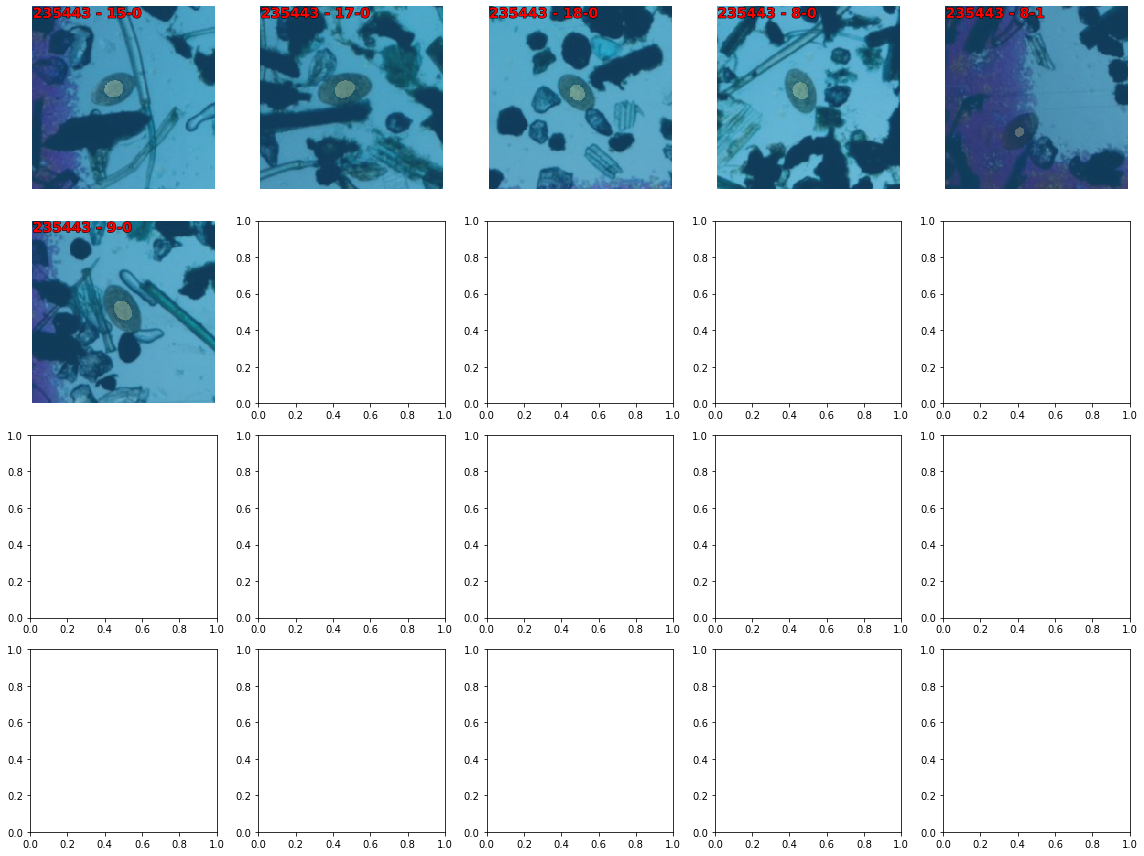

In [104]:
fnames =  sorted(get_image_files(path/'Test'))
run_inference(fnames, offset=0)

In [105]:
#run_inference(fnames, offset=20)

In [106]:
#run_inference(fnames, offset=40)

In [107]:
#run_inference(fnames, offset=60)

In [108]:
fnames =  sorted(get_image_files(path/'Test'))

# preds= iu.run_inferences(learn, fnames, start=60)
preds= run_inferences(learn, fnames, number_files='all')
len(preds)

6

In [109]:
preds

[{'filename': '235443 - 15-0.jpg',
  'y': ImageSegment (1, 200, 200),
  'pred': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]]),
  'raw_pred': tensor([[[9.9901e-01, 9.9957e-01, 9.9992e-01,  ..., 1.0000e+00,
            9.9999e-01, 1.0000e+00],
           [9.9969e-01, 9.9990e-01, 9.9997e-01,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           [9.9978e-01, 9.9986e-01, 9.9986e-01,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           ...,
           [9.9799e-01, 9.9861e-01, 9.9868e-01,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           [9.9207e-01, 9.9457e-01, 9.9515e-01,  ..., 1.0000e+00,
            1.0000e+00, 9.9999e-01],
           [9.8109e-01, 9.8903e-01, 9.9233e-01,  ..., 1.0000e+00,
            9.9997e-01, 9.9968e-01]],
  
          [[6.4708e-04, 3.4393e

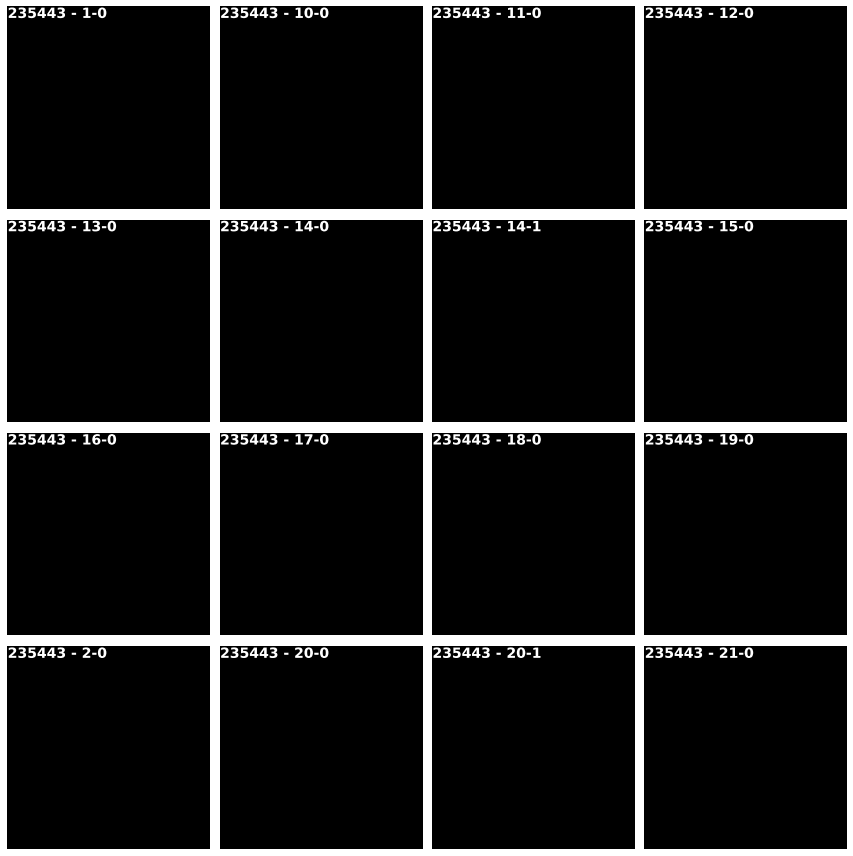

In [110]:
# Plot images and labels
fnames =  sorted(get_image_files(path/'Label'))

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    img = open_image(fnames[i])
    #pc,pi,o = learn.predict(img)
    ax = show_image(img, ax=ax)
    draw_text(ax, (0, 0), fnames[i].stem)

plt.tight_layout()

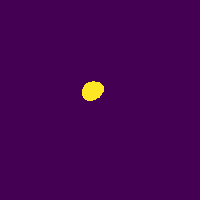

In [111]:
# for fn in fnames:
fnames =  sorted(get_image_files(path/'Test'))
fn = fnames[1] #[65]
img = open_image(fn)
pc,pi,o = learn.predict(img)
#     PIL.Image.fromarray(img.astype(np.uint8)).save(fn, quality=90)
# print(f'Label files: {len(fnames)} resaved')

pc

In [112]:
o.shape

torch.Size([4, 200, 200])

In [113]:
o

tensor([[[9.9975e-01, 9.9991e-01, 9.9999e-01,  ..., 9.9984e-01,
          9.9795e-01, 9.9702e-01],
         [9.9993e-01, 9.9998e-01, 1.0000e+00,  ..., 9.9982e-01,
          9.9918e-01, 9.9890e-01],
         [9.9995e-01, 9.9998e-01, 9.9999e-01,  ..., 9.9989e-01,
          9.9972e-01, 9.9986e-01],
         ...,
         [9.9998e-01, 1.0000e+00, 1.0000e+00,  ..., 9.9982e-01,
          9.9964e-01, 9.9973e-01],
         [9.9983e-01, 9.9997e-01, 1.0000e+00,  ..., 9.9901e-01,
          9.9750e-01, 9.9773e-01],
         [9.9943e-01, 9.9977e-01, 9.9999e-01,  ..., 9.9857e-01,
          9.9349e-01, 9.9174e-01]],

        [[2.0688e-04, 8.2085e-05, 5.2556e-06,  ..., 1.7975e-05,
          3.0576e-04, 5.3455e-04],
         [6.5862e-05, 1.6480e-05, 1.7051e-06,  ..., 1.4834e-06,
          5.3885e-05, 2.5392e-04],
         [3.4890e-05, 1.9960e-05, 7.4939e-06,  ..., 1.7218e-07,
          1.8797e-06, 1.7261e-05],
         ...,
         [1.0053e-06, 2.1738e-08, 6.6451e-10,  ..., 1.1240e-04,
          3.199

In [114]:
# 236569 - 20-0
fnames =  sorted(get_image_files(path/'Test'))
for i , fn in enumerate(fnames):
    print(i, fn)

0 testdata/Crop-200/Test/235443 - 15-0.jpg
1 testdata/Crop-200/Test/235443 - 17-0.jpg
2 testdata/Crop-200/Test/235443 - 18-0.jpg
3 testdata/Crop-200/Test/235443 - 8-0.jpg
4 testdata/Crop-200/Test/235443 - 8-1.jpg
5 testdata/Crop-200/Test/235443 - 9-0.jpg


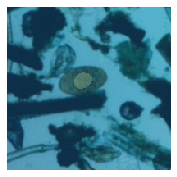

In [115]:
ax = show_image(img)
ax = show_image(pc,ax=ax, cmap='tab20', alpha=0.4)
# im = image2np(pc.cpu())

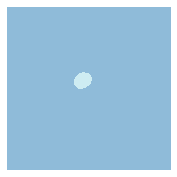

In [116]:
pc.show()

In [117]:
o

tensor([[[9.9975e-01, 9.9991e-01, 9.9999e-01,  ..., 9.9984e-01,
          9.9795e-01, 9.9702e-01],
         [9.9993e-01, 9.9998e-01, 1.0000e+00,  ..., 9.9982e-01,
          9.9918e-01, 9.9890e-01],
         [9.9995e-01, 9.9998e-01, 9.9999e-01,  ..., 9.9989e-01,
          9.9972e-01, 9.9986e-01],
         ...,
         [9.9998e-01, 1.0000e+00, 1.0000e+00,  ..., 9.9982e-01,
          9.9964e-01, 9.9973e-01],
         [9.9983e-01, 9.9997e-01, 1.0000e+00,  ..., 9.9901e-01,
          9.9750e-01, 9.9773e-01],
         [9.9943e-01, 9.9977e-01, 9.9999e-01,  ..., 9.9857e-01,
          9.9349e-01, 9.9174e-01]],

        [[2.0688e-04, 8.2085e-05, 5.2556e-06,  ..., 1.7975e-05,
          3.0576e-04, 5.3455e-04],
         [6.5862e-05, 1.6480e-05, 1.7051e-06,  ..., 1.4834e-06,
          5.3885e-05, 2.5392e-04],
         [3.4890e-05, 1.9960e-05, 7.4939e-06,  ..., 1.7218e-07,
          1.8797e-06, 1.7261e-05],
         ...,
         [1.0053e-06, 2.1738e-08, 6.6451e-10,  ..., 1.1240e-04,
          3.199

In [126]:
dirs = Dirs('testdata')

mrk_path = Path(dirs.train+'/../markup')  
mrk_path.mkdir(parents=True, exist_ok=True)

Background torch.Size([200, 200])
Liver Fluke torch.Size([200, 200])
Rumen Fluke torch.Size([200, 200])
Other torch.Size([200, 200])


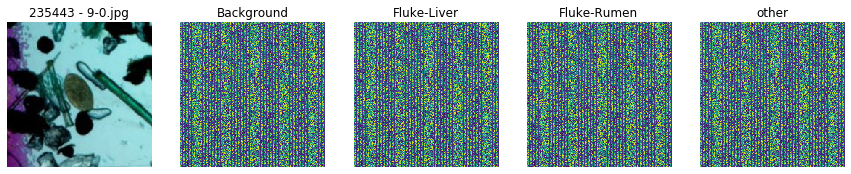

In [127]:
preds = run_prediction(learn, fn, tile=False, filesavedir=mrk_path)
for  cls, img in list(preds.items()):
    print(cls, img.shape)

# for cls,raw_pred in preds.items():
#     img = np.asarray(PIL.Image.open(fn))
#     show_img(img)
#     save_png_p(to_np(raw_pred), f'{mrk_path}/{fn.stem}-{cls}.png')


fig, axes = plt.subplots(1, 5, figsize=(15, 3))
ax = axes.flat[0]
img = open_image(fn)
im = ax.imshow(img.data.permute(1,2,0).numpy())
ax.set_axis_off()
ax.set_title(fn.name)
titles = ['Background','Fluke-Liver','Fluke-Rumen','other']
for i, ax in enumerate(axes.flat[1:]):
    arr = np.asarray(PIL.Image.open(f'{mrk_path}/{fn.stem}-{cls}.png'))
    im = ax.imshow(arr)
    ax.set_axis_off()
    ax.set_title(titles[i])

In [128]:
print("Class labels")
CLASS_LABELS

Class labels


{'Background': {'Code': 0, 'Fill': (0, 0, 0, 127)},
 'Liver Fluke': {'Code': 11, 'Fill': (255, 0, 0, 127)},
 'Rumen Fluke': {'Code': 40, 'Fill': (0, 255, 0, 127)},
 'Other': {'Code': 255, 'Fill': (0, 0, 255, 127)}}

testdata/Crop-200/Test/235443 - 9-0.jpg


[{'label': 'Liver Fluke', 'point': [98, 98], 'probability': 100},
 {'label': 'Rumen Fluke', 'point': [97, 99], 'probability': 100},
 {'label': 'Rumen Fluke', 'point': [66, 156], 'probability': 83},
 {'label': 'Other', 'point': [98, 102], 'probability': 100}]

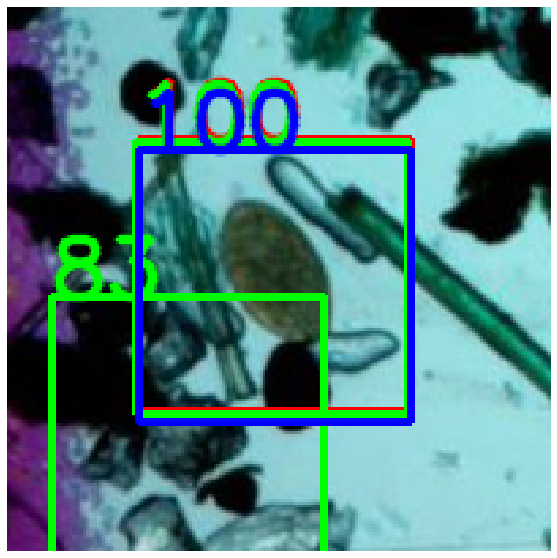

In [129]:
mrk_img, pred_list, jdata = markup_one_image(fn, preds)
show_img(mrk_img, figsize=(10,10))
print(fn)
pred_list